In [1]:
# Try a Support Vector Machine regressor with various hyperparameters, such as kernel="linear" or kernel="rbf"
# Try replacing GridSearchCV with RandomizedSearchCV
# Try adding a transformer in the preparation pipeline to select only the most important attributes
# Try creating a single pipeline that doeas full data preparation plus the final prediction
# Automatically explore sopme preparations options using GridSearchCV

In [1]:
from sklearn.svm import SVR
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
import matplotlib.pyplot as plt
from scipy.stats import expon
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.base import BaseEstimator, TransformerMixin

def train_test_StratifiedShuffleSplit():
    # the work of  spliting train/test set has been finished
    # housing = pd.read_csv(
    # "F:/jupyter_notebook_home/Linear_Regression/datasets/housing/housing.csv")
    housing = pd.read_csv(
         "G:/jupyter_notebook/Linear Regression/datasets/housing/housing.csv")
    housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3., 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set  = housing.loc[test_index]
    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis=1, inplace=True)
    housing = strat_train_set.drop("median_house_value", axis=1) 
    housing_labels = strat_train_set["median_house_value"].copy()
    housing_test = strat_test_set.drop("median_house_value", axis=1)
    housing__test_labels = strat_test_set["median_house_value"].copy()
    return housing, housing_labels, housing_test, housing__test_labels
housing, housing_labels, housing_test, housing__test_labels = train_test_StratifiedShuffleSplit()
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):      
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
# Try a Support Vector Machine regressor with various hyperparameters, such as kernel="linear" or kernel="rbf"
param_grid = [
    {"kernel": ["rbf"], "gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {"kernel": ["linear"], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
]
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_squared_error",verbose=2)
grid_search.fit(housing_prepared, housing_labels)

negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(grid_search.best_params_)

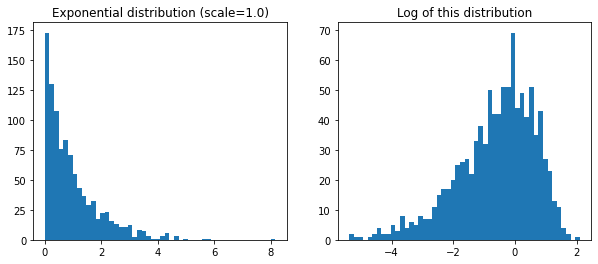

In [4]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(1000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [4]:
# Try replacing GridSearchCV with RandomizedSearchCV
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(rnd_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.2s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.3s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.3s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.3s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.5s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.7s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  11.5s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  11.4s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  11.3s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.3s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   6.1s
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.2min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.7min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.6min
[CV] END C=151136.2028

[CV] END C=60.17373642891687, gamma=1.2491263443165994, kernel=linear; total time=   6.1s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.3s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.3s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.3s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.5s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  11.8s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.6s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.7s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.7s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.6s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   6.6s
[CV] END C=55.538389

In [2]:
# Try adding a transformer in the preparation pipeline to select only the most important attributes
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [3]:
forest_reg = RandomForestRegressor()
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=2, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

k = 5
feature_importances=rnd_search.best_estimator_.feature_importances_
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices
np.array(attributes)[top_k_feature_indices]
sorted(zip(feature_importances, attributes), reverse=True)[:k]

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features[0:3]
housing_prepared[0:3, top_k_feature_indices]

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ...................max_features=7, n_estimators=180; total time=   4.4s
[CV] END ...................max_features=7, n_estimators=180; total time=   4.4s
[CV] END ....................max_features=5, n_estimators=15; total time=   0.2s
[CV] END ....................max_features=5, n_estimators=15; total time=   0.2s
[CV] END ....................max_features=3, n_estimators=72; total time=   0.9s
[CV] END ....................max_features=3, n_estimators=72; total time=   0.9s
[CV] END ....................max_features=5, n_estimators=21; total time=   0.3s
[CV] END ....................max_features=5, n_estimators=21; total time=   0.3s
[CV] END ...................max_features=7, n_estimators=122; total time=   3.0s
[CV] END ...................max_features=7, n_estimators=122; total time=   3.0s
[CV] END ....................max_features=3, n_estimators=75; total time=   0.9s
[CV] END ....................max_features=3, n_e

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

In [7]:
# Try creating a single pipeline that doeas full data preparation plus the final prediction
# import pdb
# pdb.set_trace()
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=3, cv=2, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
# feature_importances=rnd_search.best_estimator_.best_params_
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   3.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   3.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.2s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, kernel=rbf; total time=   8.7s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, kernel=rbf; total time=   8.6s


In [10]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 78685.1424422  298147.75225557  86415.85910762 147625.50312715]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


In [17]:
# Automatically explore sopme preparations options using GridSearchCV
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
#    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preparation__num__imputer__strategy': ['most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=2,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

grid_search_prep.best_params_

Fitting 2 folds for each of 16 candidates, totalling 32 fits


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   8.2s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   8.4s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   8.3s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   3.0s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   8.6s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   3.2s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   8.5s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   8.7s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   3.2s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   8.7s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=   8.7s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=   3.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=   9.1s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=   3.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=   9.3s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=   3.7s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=   9.3s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=   3.6s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=   9.4s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "D:\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=   4.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=   9.6s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=most_frequent; total time=   0.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=most_frequent; total time=   9.6s
[CV] END feature_selection__k=15, preparation__num__imputer__strategy=most_frequent; total time=   0.0s
[CV] END feature_selection__k=15, preparation__num__imputer__strategy=most_frequent; total time=   9.7s
[CV] END feature_selection__k=16, preparation__num__imputer__strategy=most_frequent; total time=   0.0s
[CV] END feature_selection__k=16, preparation__num__imputer__strategy=most_frequent; total time=   9.2s


D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "D:\anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "D:\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__


{'feature_selection__k': 1,
 'preparation__num__imputer__strategy': 'most_frequent'}

In [12]:
a = np.array([9, 4, 5, 3, 7, 9, 0, 6, 8, 3])
index_list = np.argpartition(a, 4)
print(index_list) #输出为索引
print(a[index_list]) # 可见输出最小的k个，无需严格将元素从小到大排序
print(a[index_list][:4]) # 只保证前四个元素是最小四的
# [1 6 9 3 2 7 4 5 8 0]
# [4 0 3 3 5 6 7 9 8 9]
# [4 0 3 3]
index_list = np.argpartition(a, -4)
print(index_list) 
print(a[index_list]) 
print(a[index_list][-4:]) # 只保证后四个元素是最大的四个
# [6 9 2 3 1 7 4 5 8 0]
# [0 3 5 3 4 6 7 9 8 9]
# [7 9 8 9]

[1 6 9 3 2 7 4 5 8 0]
[4 0 3 3 5 6 7 9 8 9]
[4 0 3 3]
[6 9 2 3 1 7 4 5 8 0]
[0 3 5 3 4 6 7 9 8 9]
[7 9 8 9]
